In [1]:
import numpy as np
def data_generate(num, dim, dist = 2.0, sigma = 1.0):
    x = np.zeros(shape = (num, dim,))
    y = np.zeros(shape = (num,))
    rand = np.random.rand(num)
    inds = rand < 0.2
    theta = np.zeros(shape = (dim,))
    theta[0] = -dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = 1
    inds = np.logical_and(rand >= 0.2, rand < 0.5)
    theta = np.zeros(shape = (dim,))
    theta[0] = dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = 1
    inds = np.logical_and(rand >= 0.5, rand < 0.9)
    theta = np.zeros(shape = (dim,))
    theta[1] = -dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = -1
    inds = rand >= 0.9
    theta = np.zeros(shape = (dim,))
    theta[1] = dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = -1
    return x, y
    

In [2]:
import cvxpy as cp
def erm_exponential(x, y):
    dim = x.shape[1]
    theta = cp.Variable(dim)
    intercept = cp.Variable()
    exponential = cp.sum(cp.exp(-cp.multiply(y, cp.matmul(x, theta) + intercept * np.ones_like(y))))
    obj = cp.Minimize(exponential)
    prob = cp.Problem(obj,)
    prob.solve(solver = cp.MOSEK)
    return theta.value, intercept.value

In [3]:
import cvxpy as cp
from scipy.special import xlogy
def grad_exponential(x, y, theta, intercept):
    num = x.shape[0]
    dim = x.shape[1]
    grad = np.zeros(shape = (num, theta.shape[0] + 1,))
    grad[:, :dim] = -np.einsum('i,ij->ij', np.exp(-np.multiply(y, np.matmul(x, theta) + intercept)), np.einsum('i,ij->ij', y, x))
    grad[:, dim:] = -np.einsum('i,ij->ij', np.exp(-np.multiply(y, np.matmul(x, theta) + intercept)), np.reshape(y, (-1, 1)))
    return grad

def uncert(x, theta, intercept, mu = 0.5):
    return np.exp(-mu * np.absolute(np.matmul(x, theta) + intercept))

def grad_equiv(x, y, theta, intercept, mu = 0.5):
    return np.average(np.einsum('i,ij->ij', uncert(x, theta, intercept, mu), grad_exponential(x, y, theta, intercept)), axis = 0)

def erm_equiv(x, y, mu = 0.5, tol = 1e-10, max_iter = 1e5, step_size = 1e-2, is_print = False, init = None):
    dim = x.shape[1]
    if init is None:
    # Random initialization
        theta = np.random.normal(size = dim)
        intercept = np.random.normal(size = (1,))
    else:
        theta = init[:dim]
        intercept = init[dim:]
    grad = grad_equiv(x, y, theta, intercept, mu)
    count = 0
    while np.linalg.norm(grad) > tol:
        theta -= grad[:dim] * step_size
        intercept -= grad[dim:] * step_size
        grad = grad_equiv(x, y, theta, intercept, mu)
        count += 1
        if is_print and count % 1000 == 0:
            print(count, np.linalg.norm(grad))
        if count > max_iter:
            print("max_iter")
            break
    return theta, intercept[0]

In [4]:
x, y = data_generate(num = 10000, dim = 2, dist = 2.0, sigma = 0.5)

In [5]:
theta_exponential, inter_exponential = erm_exponential(x, y)

In [6]:
theta_eq1, inter_eq1 = erm_equiv(x, y, step_size=3e-2, max_iter = 2e5, mu = 0.9, is_print = True, tol = 1e-14)

1000 2.1615153646910826e-05
2000 3.0511719032947733e-10


In [7]:
from tqdm import tqdm
def uncertain_sampling(x, y, max_iter = 1e6, step_size = 1e-3, mu = 0.5, init = None):
    num = x.shape[0]
    dim = x.shape[1]
    if init is None:
        # Random initialization
        theta = np.random.normal(size = dim)
        intercept = np.random.normal(size = (1,))
    else:
        theta = init[:dim]
        intercept = init[dim:]
    for count in tqdm(range(int(max_iter))):
        sample = np.random.randint(low=0, high=num)
        U = uncert(x[sample], theta, intercept, mu)
        tmp = np.random.rand()
        if tmp <= U:
            grad = grad_exponential(np.reshape(x[sample], (1, -1)), np.atleast_1d(y[sample]), theta, intercept).flatten()
            theta -= grad[:dim] * step_size
            intercept -= grad[dim:] * step_size
    return theta, intercept[0]

In [8]:
theta_us1, inter_us1 = uncertain_sampling(x, y, max_iter = 1e7, step_size = 3e-4, init = None, mu = 0.9)

100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [04:33<00:00, 36566.42it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


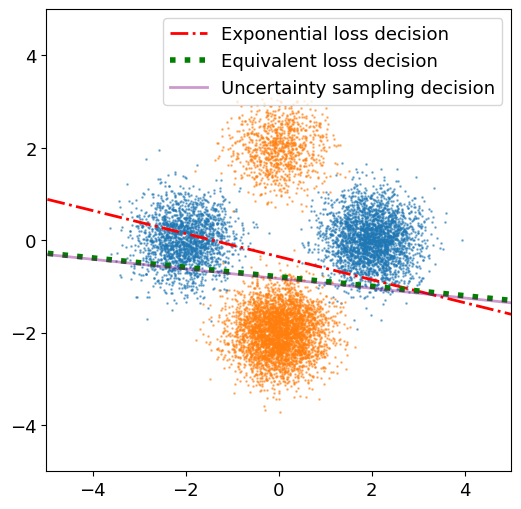

In [11]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(6, 6))
inds = y == 1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
inds = y == -1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

vert_grid = np.linspace(-6.0, 6.0, 50)
hori_exponential = (-inter_exponential - theta_exponential[1] * vert_grid) / theta_exponential[0]
plt.plot(hori_exponential, vert_grid, linestyle = 'dashdot', label = 'Exponential loss decision', color = 'red', alpha = 1.0, linewidth = 2.0)
hori_eq1 = (-inter_eq1 - theta_eq1[1] * vert_grid) / theta_eq1[0]
plt.plot(hori_eq1, vert_grid, linestyle = 'dotted', label = r'Equivalent loss decision', color = 'green', alpha = 1.0, linewidth = 4.0)
hori_us1 = (-inter_us1 - theta_us1[1] * vert_grid) / theta_us1[0]
plt.plot(hori_us1, vert_grid, linestyle = 'solid', label = r'Uncertainty sampling decision', color = 'purple', alpha = 0.4, linewidth = 2.0)
plt.legend(fontsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.savefig("Experiment1-5.eps", bbox_inches='tight')
plt.savefig("Experiment1-5.jpg", bbox_inches='tight')
plt.show()